**NEXT WORD PREDICTION USING UNIVERSAL SENTENCE ENCODER**



**Import Library** 

In [ ]:
# Getting all required libraries

import os
import re
import gdown
import numpy
import string
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from absl import logging
import tensorflow_hub as hub
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
import tensorflow.keras.backend as K
#from keras.layers.recurrent import LSTM
from keras.layers import Dense, Activation
from keras.callbacks import LambdaCallback
from keras.utils.data_utils import get_file
#from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split


**Data preparation - Generating Corpus**


In [ ]:

url = ' https://drive.google.com/uc?id=1YTBR7FiXssaKXHhOZbUbwoWw6jzQxxKW'
output = 'corpus.txt'
gdown.download(url, output, quiet=False)

# sentence_length = 40

# Read local file from directory
with open('corpus.txt') as subject:
  cache = subject.readlines()
translator = str.maketrans('', '', string.punctuation) # Remove punctuation
lines = [doc.lower().translate(translator) for doc in cache] # Switch to lower case

Downloading...
From:  https://drive.google.com/uc?id=1YTBR7FiXssaKXHhOZbUbwoWw6jzQxxKW
To: /content/corpus.txt
100%|██████████| 7.55M/7.55M [00:00<00:00, 28.6MB/s]


In [ ]:
# print(lines[0][:100])
 #len(lines)

In [ ]:
# Generate an list of single/independent words

vocabulary = list(set(' '.join(lines).replace('\n','').split(' ')))
primary_store = {}
for strings, texts in enumerate(vocabulary):
  primary_store[texts] = strings

In [ ]:
# PREVIEW OUTPUT ::

# print(vocabulary[:50])
# len(vocabulary)

In [ ]:
# Splitting data into Train sets and test sets

X = [] 
y = []

for c in lines:
  xxxx = c.replace('\n','').split(' ')
  X.append(' '.join(xxxx[:-1])) # X from the corpus

  yyyy = [0 for i in range(len(vocabulary))] # Generate Y from the Vocabulary
  # yyyy[primary_store[xxxx[-1]]] = 1
  yyyy[primary_store[xxxx[-1]]] = 1
  y.append(yyyy)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_test = numpy.array(y_test)
y_train = numpy.array(y_train)

In [ ]:
# PREVIEW OUTPUT ::

# print(X_train[:10])
# print(y_train[:10])
# print(X_test[:10])
# print(y_test[:10])

**Embeddings!**


In [ ]:
# Import the Universal Sentence Encoder's TF Hub module (Here we're making use of version 4)
# This will take a while but won't be long :)

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"  
appreciate = hub.load(module_url)

# Making it easier - Function for embedding
def embed(goodness):
  return appreciate(goodness)

In [ ]:
# REVIEW OUTPUT ::

# appreciate.variables

In [ ]:
# Wrapping up with the U-S-E

X_train = embed(X_train)
X_test = embed(X_test)
X_train = X_train.numpy()
X_test = X_test.numpy()

In [ ]:
# PREVIEW OUTPUT ::

# print(X_train[:10])
# print(y_train[:10])
# print(X_test[:10])
# print(y_test[:10])
# print(X_train.shape, X_test.shape, y_test.shape, y_train.shape)

**Building the model**


In [ ]:
model = Sequential()
# model.add(Embedding(input_dim=len(vocabulary), output_dim=100))
model = Sequential()
# model.add(LSTM(units=100, input_shape=[512]))
model.add(Dense(512, input_shape=[512], activation = 'relu'))
model.add(Dense(units=len(vocabulary), activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 2694)              1382022   
                                                                 
Total params: 1,644,678
Trainable params: 1,644,678
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training the model. 

history = model.fit(X_train, y_train, batch_size=512, shuffle=True, epochs=20, validation_data=(X_test, y_test), callbacks=[LambdaCallback()])

Epoch 1/20
11/11 [==============================] - 3s 206ms/step - loss: 7.6381 - acc: 0.0772 - val_loss: 6.9790 - val_acc: 0.0694
Epoch 2/20
11/11 [==============================] - 2s 183ms/step - loss: 5.8886 - acc: 0.0600 - val_loss: 4.4898 - val_acc: 0.0550
Epoch 3/20
11/11 [==============================] - 2s 186ms/step - loss: 4.2207 - acc: 0.0693 - val_loss: 4.0868 - val_acc: 0.0956
Epoch 4/20
11/11 [==============================] - 2s 176ms/step - loss: 3.9848 - acc: 0.1548 - val_loss: 3.8710 - val_acc: 0.2050
Epoch 5/20
11/11 [==============================] - 2s 177ms/step - loss: 3.7669 - acc: 0.2046 - val_loss: 3.6215 - val_acc: 0.2639
Epoch 6/20
11/11 [==============================] - 2s 174ms/step - loss: 3.4785 - acc: 0.3187 - val_loss: 3.2987 - val_acc: 0.4244
Epoch 7/20
11/11 [==============================] - 2s 172ms/step - loss: 3.1191 - acc: 0.4865 - val_loss: 2.9033 - val_acc: 0.6467
Epoch 8/20
11/11 [==============================] - 2s 169ms/step - loss: 2.

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.show()

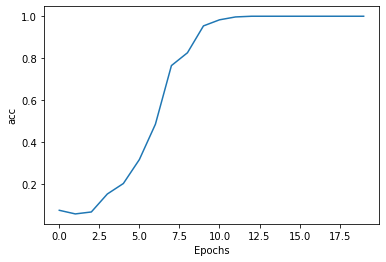

In [ ]:
plot_graphs(history, 'acc')

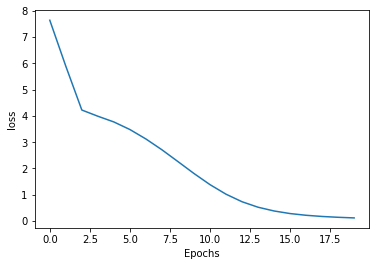

In [ ]:
plot_graphs(history, 'loss')

**Unto the tests!**

In [ ]:
# Create function to predict and show detailed output

def next_word(collection=[], extent=1):

  for item in collection:
    text = item
    for i in range(extent):
      prediction = model.predict(x=embed([item]).numpy())
      idx = np.argmax(prediction[-1])
      item += ' ' + vocabulary[idx]
      
      print(text + ' --> ' + item + '\nNEXT WORD: ' + item.split(' ')[-1] + '\n')

In [ ]:
# Tests - please feel free to explore

single_text = ['and some other essential']

next_word(single_text)

1/1 [==============================] - 0s 82ms/step
and some other essential --> and some other essential networks
NEXT WORD: networks



In [ ]:
# Testing on a collection of words

text_collection = ['deep convolutional', 'simple and effective', 'a nonconvex', 'a']

next_word(text_collection)

1/1 [==============================] - 0s 18ms/step
deep convolutional --> deep convolutional networks
NEXT WORD: networks

1/1 [==============================] - 0s 19ms/step
simple and effective --> simple and effective estimators
NEXT WORD: estimators

1/1 [==============================] - 0s 18ms/step
a nonconvex --> a nonconvex dataset
NEXT WORD: dataset

1/1 [==============================] - 0s 22ms/step
a --> a accuracy
NEXT WORD: accuracy



**For the record**

In [ ]:

vocabulary = numpy.array(vocabulary)
numpy.save('./vocabulary.npy', vocabulary)
model.save('./NWP-USE')